In [2]:
import sys
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [4]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../mat/'+strategyname+'.mat')

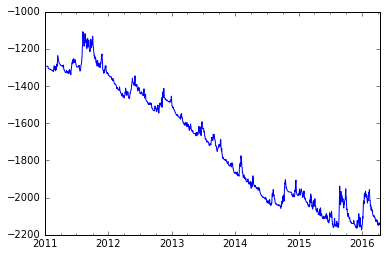

In [5]:
d.exo.plot();

In [6]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

# Init simple MA crossover swarming algo

In [7]:
data = {}
for slowp in np.arange(10, 20, 1):
        for fastp in np.arange(2, 10, 2):
            slow_ma = d.exo.rolling(slowp).mean()
            fast_ma = d.exo.rolling(fastp).mean()

            short_entry = CrossDown(fast_ma, slow_ma)
            short_exit = CrossUp(fast_ma, slow_ma)

            direction = -1
            pl1, inposition1 = backtester.backtest(d, short_entry, short_exit, direction )
            #trades = backtester.trades(pl1, inposition1)
            equity, stats = backtester.stats(pl1, inposition1)
            data[ str((slowp, fastp)) ] = equity

In [8]:
df = pd.DataFrame.from_dict(data)

In [9]:
class SwarmRank(object):
    """
    Swarm ranking common class
    """
    def __init__(self, reranktime):
        self.reranktime = reranktime
        
    def rank_highestret(self, eqty):
        """
        Ranking function
        Calculate last 14 days equity returns, excluding out-of-market time
        """
        
        if len(self.reranktime) != len(eqty):
            raise ValueError('Length of self.reranktime != equity length')
            
        result = np.full_like(eqty, np.nan)
        
        for i in range(len(self.reranktime)):            
            # Skip 14 days
            if i < 15:
                continue
                        
            if self.reranktime[i]:
                # We at the point of reranking
                
                # Skip periods without trades
                e = np.unique(eqty[:i+1])
                
                if len(e) < 15:
                    continue
                    
                # Recalculate last 14 period returns
                result[i] = e[len(e) - 1] - e[len(e) - 14]
                
        return pd.Series(result, index=eqty.index)

# Run swarm picking routine

In [10]:
# Number of swarm members to pick
nSystems = 5

# Rebalance the swarm every Monday
rerank_time = df.index.dayofweek == 0

# Rank systems
ranking_algo =  SwarmRank(rerank_time)

# Last 14 days returns rank
rets = df.apply(ranking_algo.rank_highestret)
rnk = rets.rank(axis=1, pct=True)


is_picked_df = pd.DataFrame(False, index=df.index, columns=df.columns)
nbest = None

for i in range(len(rerank_time)):
    if i < 100:
        continue 
    if rerank_time[i]:
        # Select N best ranked systems to trade
        nbest = rnk.iloc[i].sort_values()
        
        # Filter early trades
        if nbest.sum() == 0:
            nbest[:] = False
            continue
        
        # Flagging picked trading systems
        nbest[-nSystems:] = True
        nbest[:-nSystems] = False
        is_picked_df.iloc[i] = nbest        
        
    else:
        # Flag last picked swarm members untill new rerank_time
        if nbest is not None:
            is_picked_df.iloc[i] = nbest       

# Swarm picking results comparison


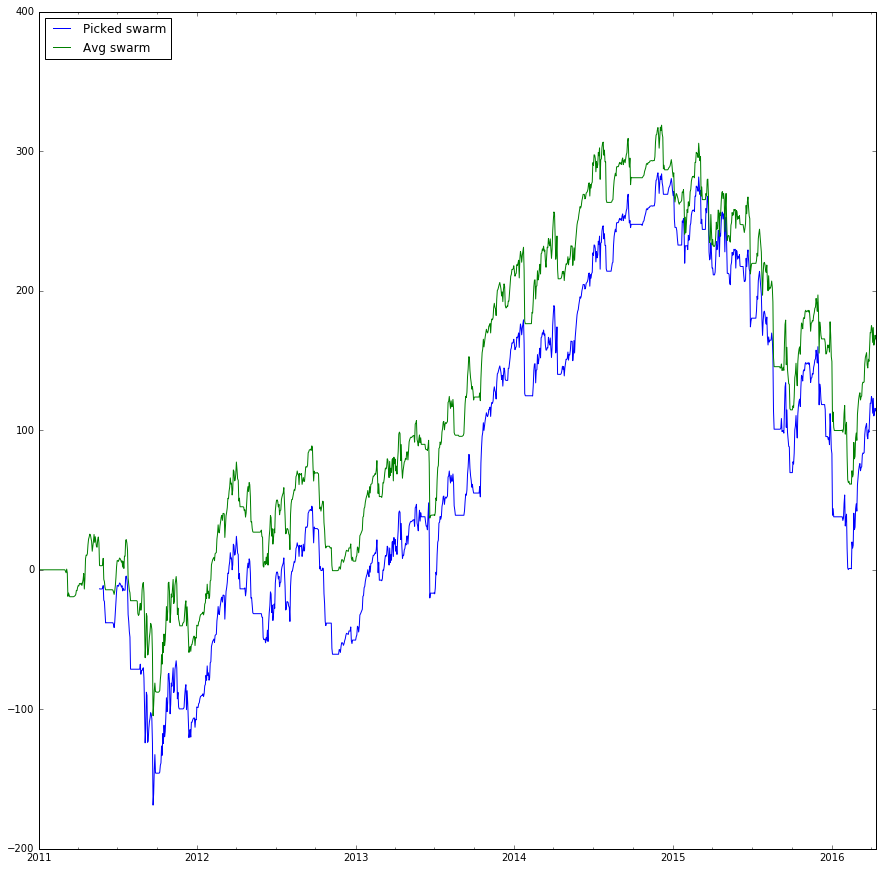

In [11]:
figsize(15,15)

#
# Compose average equity for picked swarms members and all-in-one average
#
eq_changes = df.diff()
avg_picked_equity = eq_changes[is_picked_df].mean(axis=1).cumsum()
avg_all_equity = eq_changes.mean(axis=1).cumsum()


avg_picked_equity.plot(label='Picked swarm')
avg_all_equity.plot(c='g', label='Avg swarm')
legend(loc=2)

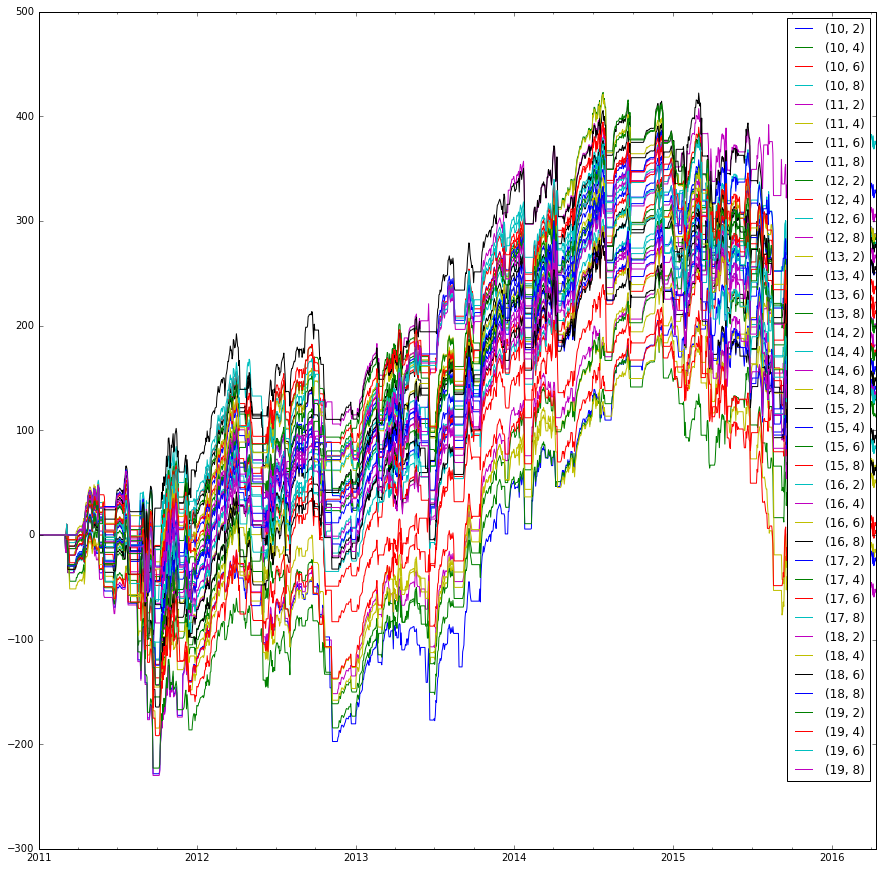

In [12]:
#
# Compose average equity for picked swarms members and all-in-one average
#
eq_changes = df.diff()
avg_all_equity = eq_changes.cumsum().plot()